<a href="https://colab.research.google.com/github/n-bzy/iannwtf/blob/main/homework07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepare Dataset

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

train_ds, val_ds = tfds.load('mnist', split=['train','test'], as_supervised=True)

def preprocess(data, seq):
    """Preprocessing the training and testing data for the LSTM network"""

    # Add first digit, subtract second, add third, subtract fourth
    l = list()
    for i, elem in enumerate(data):
        if (i% seq) == 0:
            l.append(int(elem[1]))
        else:
            if (i%2)==0:
                l.append(int(l[i-1] + elem[1]))
            else:
                l.append(int(l[i-1] - elem[1]))
    
    # Convert list of new targets to dataset            
    new_t = tf.data.Dataset.from_tensor_slices(l)
    # Zip old dataset and new targets
    data = tf.data.Dataset.zip((data, new_t))
    # Replace old with new targets
    data = data.map(lambda x, t: (x[0], t))

    data = data.map(lambda x, t: (tf.cast(x, tf.float32), t))
    data = data.map(lambda x, t: ((x/128.)-1., t))

    # Create sequences
    data = data.window(seq)

    data = data.cache()
    data = data.shuffle(1000)
    data = data.map(lambda x,t: (x.batch(seq).get_single_element(), t.batch(seq).get_single_element()))
    data = data.batch(32)
    data = data.prefetch(tf.data.AUTOTUNE)

    return data

train = preprocess(train_ds, seq=4)
val = preprocess(val_ds, seq=4)

# Check shape of inputs and targets
for x,t in train.take(1):
    print(x.shape, t.shape)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to ~/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.
(32, 4, 28, 28, 1) (32, 4)


# Basic CNN

In [2]:
class CNN(tf.keras.Model):
    """Basic CNN structure for processing of mnist images"""
    def __init__(self):
        super().__init__()

        self.layer1 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')
        self.pool1 = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
        # Image size 14x14
        self.layer2 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')
        self.pool2 = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
        # Image size 7x7
        self.layer3 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')
        self.pool3 = tf.keras.layers.TimeDistributed(tf.keras.layers.GlobalAveragePooling2D())

    def __call__(self, x):
        x = self.layer1(x)
        x = self.pool1(x)
        x = self.layer2(x)
        x = self.pool2(x)
        x = self.layer3(x)
        x = self.pool3(x)
        return x

# LSTM Cell

In [3]:
class LSTMCell(tf.keras.layers.AbstractRNNCell):
    """Create a LSTM Cell"""
    def __init__(self, hidden_state, cell_state):
        """Initialize LSTM Cell with Forget Gate, Input Gate, Cell State
        Candidate Gate and Output Gate"""
        super().__init__()

        self.hidden_state = hidden_state
        self.cell_state = cell_state

        self.linear = tf.keras.layers.Dense(hidden_state)

        self.forget_gate = tf.keras.layers.Dense(cell_state, 
                                             kernel_initializer= tf.keras.initializers.Orthogonal(gain=1.0, seed=None),
                                             activation=tf.nn.sigmoid)
        self.input_gate = tf.keras.layers.Dense(cell_state, 
                                             kernel_initializer= tf.keras.initializers.Orthogonal(gain=1.0, seed=None),
                                             activation=tf.nn.sigmoid)
        self.candidate_gate = tf.keras.layers.Dense(cell_state, 
                                             kernel_initializer= tf.keras.initializers.Orthogonal(gain=1.0, seed=None),
                                             activation=tf.nn.tanh)
        self.output_gate = tf.keras.layers.Dense(hidden_state, 
                                             kernel_initializer= tf.keras.initializers.Orthogonal(gain=1.0, seed=None),
                                             activation=tf.nn.sigmoid)

    @property
    def state_size(self):
        return [tf.TensorShape([self.hidden_state]), 
                tf.TensorShape([self.cell_state])]
    @property
    def output_size(self):
        return [tf.TensorShape([self.hidden_state])]
    
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        return [tf.zeros([self.hidden_state]), 
                tf.zeros([self.cell_state])]

    def __call__(self, x, states):
        hidden = states[0]
        cell = states[1]
        x = hidden + self.linear(x)

        f = self.forget_gate(x)
        i = self.input_gate(x)
        c_hat = self.candidate_gate(x)

        new_cell_state = f*cell + i*c_hat

        y = self.output_gate(x)*tf.math.tanh(new_cell_state)
        new_hidden_state = y

        return y, [new_hidden_state, new_cell_state]

# RNN

In [4]:
class RNN(tf.keras.Model):
    """Create a RNN out of LSTM cells with additional CNN"""
    def __init__(self):
        """Initialize the CNN, RNN and output layer"""
        super().__init__()

        self.cnn = CNN()

        self.lstm_cell = LSTMCell(hidden_state=24, cell_state=24)
        self.rnn_layer = tf.keras.layers.RNN(self.lstm_cell, return_sequences=True, unroll=True)
        
        self.output_layer = tf.keras.layers.Dense(1, activation=None)
        
        self.metrics_list = [tf.keras.metrics.Mean(name="loss")]

        self.optimizer = tf.keras.optimizers.Adam()
        self.loss = tf.keras.losses.MeanSquaredError()

    @property
    def metrics(self):
        return self.metrics_list
    
    def reset_metrics(self):
        for metric in self.metrics:
            metric.reset_state()
        
    def call(self, x, training=False):
        x = self.cnn(x)
        x = self.rnn_layer(x)
        x = self.output_layer(x)
        return x

    @tf.function
    def train(self, data):
        x,t = data
        with tf.GradientTape() as tape:
            y = self(x, training=True)
            loss = self.loss(t, y)
        gradients = tape.gradient(loss, self.trainable_variables)
        
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        
        self.metrics[0].update_state(loss)
        
        return {m.name : m.result() for m in self.metrics}
    
    @tf.function
    def test(self, data):
        
        x,t = data
        y = self(x, training=False)
        loss = self.loss(t, y)
                
        self.metrics[0].update_state(loss)
        
        return {m.name : m.result() for m in self.metrics} 

In [5]:
# Initialize model
model_test = RNN()
model_test(tf.keras.Input((4,28,28,1)));
model_test.summary()

Model: "rnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cnn (CNN)                   multiple                  0 (unused)
                                                                 
 lstm_cell (LSTMCell)        multiple                  5496      
                                                                 
 rnn_1 (RNN)                 multiple                  5496      
                                                                 
 dense_5 (Dense)             multiple                  25        
                                                                 
Total params: 227,603
Trainable params: 227,601
Non-trainable params: 2
_________________________________________________________________


# Training loop

In [6]:
import tqdm

def training_loop(model, train, val, epochs):
    """Train and test the RNN for given epochs on given data"""

    # Save loss and accuracy as dictionaries in a list for visualization
    lists = []

    for n in range(epochs):
        print(f"Epoch {n}:")

        for data in tqdm.tqdm(train, position=0, leave=True):
            metrics = model.train(data)

        # Add metrics to list
        lists.append(metrics)
        print([f"{key}: {value.numpy()}" for (key,value) in metrics.items()])
        model.reset_metrics()

        for data in tqdm.tqdm(val, position=0, leave=True):
            metrics = model.test(data)

        # Add metrics to list
        lists.append(metrics)
        print([f"{key}: {value.numpy()}" for (key,value) in metrics.items()])
        model.reset_metrics()
        
    return lists

li = training_loop(model_test, train, val, epochs=15)

Epoch 0:


100%|██████████| 469/469 [00:16<00:00, 28.68it/s]


['loss: 23.085275650024414']


100%|██████████| 79/79 [00:01<00:00, 58.03it/s]


['loss: 19.30060577392578']
Epoch 1:


100%|██████████| 469/469 [00:04<00:00, 114.00it/s]


['loss: 12.509130477905273']


100%|██████████| 79/79 [00:00<00:00, 185.00it/s]


['loss: 5.0360331535339355']
Epoch 2:


100%|██████████| 469/469 [00:04<00:00, 113.28it/s]


['loss: 3.8201780319213867']


100%|██████████| 79/79 [00:00<00:00, 125.57it/s]


['loss: 2.782270669937134']
Epoch 3:


100%|██████████| 469/469 [00:04<00:00, 98.81it/s]


['loss: 2.371634006500244']


100%|██████████| 79/79 [00:00<00:00, 112.83it/s]


['loss: 2.435502767562866']
Epoch 4:


100%|██████████| 469/469 [00:04<00:00, 111.41it/s]


['loss: 1.7870687246322632']


100%|██████████| 79/79 [00:00<00:00, 125.36it/s]


['loss: 1.689123272895813']
Epoch 5:


100%|██████████| 469/469 [00:04<00:00, 112.95it/s]


['loss: 1.4694336652755737']


100%|██████████| 79/79 [00:00<00:00, 188.97it/s]


['loss: 1.603351354598999']
Epoch 6:


100%|██████████| 469/469 [00:05<00:00, 91.77it/s] 


['loss: 1.2637848854064941']


100%|██████████| 79/79 [00:00<00:00, 125.03it/s]


['loss: 1.2622135877609253']
Epoch 7:


100%|██████████| 469/469 [00:04<00:00, 112.48it/s]


['loss: 1.1368260383605957']


100%|██████████| 79/79 [00:00<00:00, 124.90it/s]


['loss: 1.2089147567749023']
Epoch 8:


100%|██████████| 469/469 [00:05<00:00, 91.76it/s] 


['loss: 1.0006747245788574']


100%|██████████| 79/79 [00:00<00:00, 175.30it/s]


['loss: 1.1794605255126953']
Epoch 9:


100%|██████████| 469/469 [00:05<00:00, 91.74it/s] 


['loss: 0.8701530694961548']


100%|██████████| 79/79 [00:00<00:00, 125.31it/s]


['loss: 1.1298469305038452']
Epoch 10:


100%|██████████| 469/469 [00:04<00:00, 112.30it/s]


['loss: 0.783440887928009']


100%|██████████| 79/79 [00:00<00:00, 177.13it/s]


['loss: 1.0702201128005981']
Epoch 11:


100%|██████████| 469/469 [00:04<00:00, 111.94it/s]


['loss: 0.7015368342399597']


100%|██████████| 79/79 [00:00<00:00, 125.80it/s]


['loss: 0.931515634059906']
Epoch 12:


100%|██████████| 469/469 [00:04<00:00, 111.26it/s]


['loss: 0.6561833620071411']


100%|██████████| 79/79 [00:00<00:00, 202.35it/s]


['loss: 0.8867912888526917']
Epoch 13:


100%|██████████| 469/469 [00:05<00:00, 91.68it/s] 


['loss: 0.5854371190071106']


100%|██████████| 79/79 [00:00<00:00, 125.25it/s]


['loss: 0.8770574331283569']
Epoch 14:


100%|██████████| 469/469 [00:04<00:00, 111.50it/s]


['loss: 0.5255376696586609']


100%|██████████| 79/79 [00:00<00:00, 124.80it/s]

['loss: 0.8552876710891724']


# Visualization

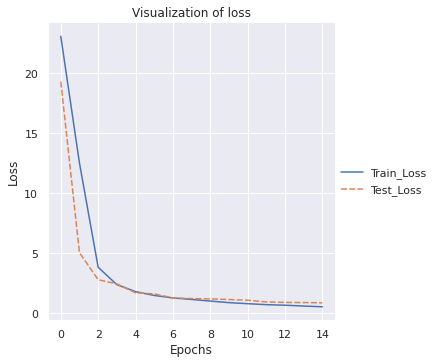

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def visualization(lists):
    """Visualizes accuracy and loss for training and test data """

    # Create lists for each visualized metric
    epochs = np.array([*range(15)])
    train_loss = np.zeros(epochs.size)
    test_loss = np.zeros(epochs.size)

    # Counter used for splitting the input
    c,i = 0,0
    # Split up the metrics to the corresponding arrays
    for k in range(len(lists)):
        if k%2 == 1:
            test_loss[i] = lists[k]['loss'].numpy()
            i += 1
        else:
            train_loss[c] = lists[k]['loss'].numpy()
            c += 1
    
    # Create dictionary with all metrics
    data= {'Train_Loss':train_loss, 'Test_Loss':test_loss}

    # Plot the metrics
    sns.set_theme()
    sns.relplot(data=data, kind='line').set(title='Visualization of loss',xlabel='Epochs', ylabel='Loss')

visualization(li)